# Setup & Imports

In [1]:
# ===== Standard Library =====
import os
import random
import csv
from pathlib import Path

# ===== Math & Data =====
import numpy as np

# ===== Visualization =====
import matplotlib.pyplot as plt
from PIL import Image

# ===== TensorFlow & Addons =====
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

# ===== Custom Modules =====
import MiFID as mf

# ===== TPU / Strategy Setup =====
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()

print('Number of replicas:', strategy.num_replicas_in_sync)

# ===== Autotune & Version Info =====
AUTOTUNE = tf.data.experimental.AUTOTUNE
print(tf.__version__)

Number of replicas: 1
2.6.2



TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
 The versions of TensorFlow you are currently using is 2.6.2 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


# Load in the data

We want to keep our photo dataset and our Monet dataset separate. First, load in the filenames of the TFRecords.

In [2]:
GCS_PATH = './gan-getting-started/'

In [3]:
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


All the images for the competition are already sized to 256x256. As these images are RGB images, set the channel to 3. Additionally, we need to scale the images to a [-1, 1] scale. Because we are building a generative model, we don't need the labels or the image id so we'll only return the image from the TFRecord.

In [4]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image


def read_tfrecord_with_name(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string),
    }
    ex = tf.io.parse_single_example(example, tfrecord_format)
    img = decode_image(ex["image"])      
    return img, ex["image_name"]


def read_tfrecord(example):
    img, _ = read_tfrecord_with_name(example)
    return img

Define the function to extract the image from the files.

In [5]:
def load_dataset(filenames, labeled=True, ordered=False, with_name=False):
    ds = tf.data.TFRecordDataset(filenames)
    if with_name:
        ds = ds.map(read_tfrecord_with_name, num_parallel_calls=AUTOTUNE)
    else:
        ds = ds.map(read_tfrecord,            num_parallel_calls=AUTOTUNE)
    return ds

Let's load in our datasets.

In [6]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

2025-08-19 12:30:04.774821: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-19 12:30:04.942514: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46566 MB memory:  -> device: 0, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:21:00.0, compute capability: 8.9


Photos Preprocessing

In [7]:
def compute_channel_stats(ds, take=None):
    total = 0
    s  = np.zeros(3, dtype=np.float64)
    s2 = np.zeros(3, dtype=np.float64)
    it = ds if take is None else ds.take(take)
    for img in it:                               
        if isinstance(img, (tuple, list)):
            img = img[0]
        x = img.numpy().reshape(-1, 3).astype(np.float64)  # [-1,1]
        s  += x.sum(axis=0)
        s2 += np.square(x).sum(axis=0)
        total += x.shape[0]
    mean = s / total
    var  = s2 / total - np.square(mean)
    std  = np.sqrt(np.maximum(var, 1e-12))
    return mean.astype(np.float32), std.astype(np.float32)

def build_channel_matcher(src_mean, src_std, tgt_mean, tgt_std):
    scale = (tgt_std / np.maximum(src_std, 1e-8)).astype(np.float32)
    shift = (tgt_mean - src_mean * scale).astype(np.float32)
    scale_tf = tf.constant(scale, dtype=tf.float32)
    shift_tf = tf.constant(shift, dtype=tf.float32)
    def preprocess(img):
        y = img * scale_tf + shift_tf
        return tf.clip_by_value(y, -1.0, 1.0)
    return preprocess, scale, shift

# compute stats on datasets
photo_mean, photo_std = compute_channel_stats(photo_ds)
monet_mean, monet_std = compute_channel_stats(monet_ds)

# build the preprocessing fn and apply it to the photo stream
preprocess_photo_to_monet, scale_vec, shift_vec = build_channel_matcher(
    photo_mean, photo_std, monet_mean, monet_std
)
photo_ds = photo_ds.map(preprocess_photo_to_monet, num_parallel_calls=tf.data.AUTOTUNE)


2025-08-19 12:30:05.448185: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


# Build the generator

We'll be using a UNET architecture for our CycleGAN. To build our generator, let's first define our `downsample` and `upsample` methods.

The `downsample`, as the name suggests, reduces the 2D dimensions, the width and height, of the image by the stride. The stride is the length of the step the filter takes. Since the stride is 2, the filter is applied to every other pixel, hence reducing the weight and height by 2.

We'll be using an instance normalization instead of batch normalization. As the instance normalization is not standard in the TensorFlow API, we'll use the layer from TensorFlow Add-ons.

In [8]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

`Upsample` does the opposite of downsample and increases the dimensions of the of the image. `Conv2DTranspose` does basically the opposite of a `Conv2D` layer.

In [9]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

SelfAttention - REMOVED

Let's build our generator!

The generator first downsamples the input image and then upsample while establishing long skip connections. Skip connections are a way to help bypass the vanishing gradient problem by concatenating the output of a layer to multiple layers instead of only one. Here we concatenate the output of the downsample layer to the upsample layer in a symmetrical fashion.

In [10]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # Larger down_stack with more filters
    down_stack = [
        downsample(96, 4, apply_instancenorm=False), # (bs, 128, 128, 96) - increased from 64
        downsample(192, 4), # (bs, 64, 64, 192) - increased from 128
        downsample(384, 4), # (bs, 32, 32, 384) - increased from 256
        downsample(768, 4), # (bs, 16, 16, 768) - increased from 512
        downsample(768, 4), # (bs, 8, 8, 768)
        downsample(768, 4), # (bs, 4, 4, 768)
        downsample(768, 4), # (bs, 2, 2, 768)
        downsample(768, 4), # (bs, 1, 1, 768)
    ]

    # Larger up_stack with corresponding filter increases
    up_stack = [
        upsample(768, 4, apply_dropout=True), # (bs, 2, 2, 1536)
        upsample(768, 4, apply_dropout=True), # (bs, 4, 4, 1536)
        upsample(768, 4, apply_dropout=True), # (bs, 8, 8, 1536)
        upsample(768, 4), # (bs, 16, 16, 1536)
        upsample(384, 4), # (bs, 32, 32, 768) - increased from 256
        upsample(192, 4), # (bs, 64, 64, 384) - increased from 128
        upsample(96, 4), # (bs, 128, 128, 192) - increased from 64
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model with more self-attention
    skips = []
    for i, down in enumerate(down_stack):
        x = down(x)

        skips.append(x)
    
    skips = reversed(skips[:-1])
    
    # Upsampling and establishing the skip connections with more self-attention
    for i, (up, skip) in enumerate(zip(up_stack, skips)):
        x = up(x)
        x = layers.Concatenate()([x, skip])
        # Add self-attention at more upsampling layers

    
    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

# Build the discriminator

The discriminator takes in the input image and classifies it as real or fake (generated). Instead of outputing a single node, the discriminator outputs a smaller 2D image with higher pixel values indicating a real classification and lower values indicating a fake classification.

In [11]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    # Larger discriminator with more layers and filters
    down1 = downsample(96, 4, False)(x) # (bs, 128, 128, 96) - increased from 64
    down2 = downsample(192, 4)(down1) # (bs, 64, 64, 192) - increased from 128
    down3 = downsample(384, 4)(down2) # (bs, 32, 32, 384) - increased from 256
    
    # Add self-attention to discriminator
    
    # Additional layer for larger discriminator
    down4 = downsample(768, 4)(down3) # (bs, 16, 16, 768) - new layer

    zero_pad1 = layers.ZeroPadding2D()(down4) # (bs, 18, 18, 768)
    conv = layers.Conv2D(768, 4, strides=1,  # increased from 512
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 15, 15, 768)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 17, 17, 768)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 14, 14, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

Since our generators are not trained yet, the generated Monet-esque photo does not show what is expected at this point.

VGG Feature Extractor for Perceptual Loss


In [12]:
# VGG Feature Extractor for Perceptual Loss
def create_vgg_feature_extractor():
    vgg = tf.keras.applications.VGG19(weights='imagenet', include_top=False)
    
    # Make all layer names unique by adding prefix
    for layer in vgg.layers:
        layer._name = f"vgg_perceptual_{layer.name}"
    
    # Extract features from multiple layers
    layer_names = ['vgg_perceptual_block1_conv1', 'vgg_perceptual_block2_conv1', 
                   'vgg_perceptual_block3_conv1', 'vgg_perceptual_block4_conv1', 
                   'vgg_perceptual_block5_conv1']
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    model.trainable = False
    
    # Also rename the final model
    model._name = "vgg_perceptual_feature_extractor"
    
    return model

# Initialize VGG feature extractor
with strategy.scope():
    vgg_feature_extractor = create_vgg_feature_extractor()

# Build the CycleGAN model

We will subclass a `tf.keras.Model` so that we can run `fit()` later to train our model. During the training step, the model transforms a photo to a Monet painting and then back to a photo. The difference between the original photo and the twice-transformed photo is the cycle-consistency loss. We want the original photo and the twice-transformed photo to be similar to one another.

The losses are defined in the next section.

In [13]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
        vgg_feature_extractor=None,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        self.vgg_feature_extractor = vgg_feature_extractor
        self.lambda_lsgan = 0.5
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn,
        perceptual_loss_fn,
        lsgan_gen_loss_fn,
        lsgan_disc_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        self.perceptual_loss_fn = perceptual_loss_fn
        self.lsgan_gen_loss_fn = lsgan_gen_loss_fn
        self.lsgan_disc_loss_fn = lsgan_disc_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)
            monet_lsgan_gen_loss = self.lsgan_gen_loss_fn(disc_fake_monet)
            photo_lsgan_gen_loss = self.lsgan_gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates perceptual loss
            monet_perceptual_loss = self.perceptual_loss_fn(real_photo, fake_monet, self.vgg_feature_extractor)
            photo_perceptual_loss = self.perceptual_loss_fn(real_monet, fake_photo, self.vgg_feature_extractor)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle) + monet_perceptual_loss + self.lambda_lsgan * monet_lsgan_gen_loss
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle) + photo_perceptual_loss + self.lambda_lsgan * photo_lsgan_gen_loss

            # evaluates discriminator loss
            monet_lsgan_disc_loss = self.lsgan_disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_lsgan_disc_loss = self.lsgan_disc_loss_fn(disc_real_photo, disc_fake_photo)

            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet) + self.lambda_lsgan * monet_lsgan_disc_loss
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo) + self.lambda_lsgan * photo_lsgan_disc_loss

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

# Define loss functions

The discriminator loss function below compares real images to a matrix of 1s and fake images to a matrix of 0s. The perfect discriminator will output all 1s for real images and all 0s for fake images. The discriminator loss outputs the average of the real and generated loss.

In [14]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [15]:
with strategy.scope():
    def lsgan_discriminator_loss(real, generated):
        # LSGAN discriminator loss: ½E[(D(x) - 1)²] + ½E[(D(G(z)))²]
        real_loss = tf.reduce_mean(tf.square(real - 1.0))
        generated_loss = tf.reduce_mean(tf.square(generated - 0.0))
        total_lsgan_disc_loss = real_loss + generated_loss
        return total_lsgan_disc_loss * 0.5

The generator wants to fool the discriminator into thinking the generated image is real. The perfect generator will have the discriminator output only 1s. Thus, it compares the generated image to a matrix of 1s to find the loss.

In [16]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [17]:
with strategy.scope():
    def lsgan_generator_loss(generated):
        # LSGAN generator loss: ½E[(D(G(z)) - 1)²]
        return tf.reduce_mean(tf.square(generated - 1.0))

We want our original photo and the twice transformed photo to be similar to one another. Thus, we can calculate the cycle consistency loss be finding the average of their difference.

In [18]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [19]:
with strategy.scope():
    def perceptual_loss(real_image, generated_image, vgg_model, lambda_perceptual=0.002):  
        # Preprocess images for VGG (convert from [-1,1] to [0,255] and then normalize)
        real_processed = tf.keras.applications.vgg19.preprocess_input((real_image + 1) * 127.5)
        generated_processed = tf.keras.applications.vgg19.preprocess_input((generated_image + 1) * 127.5)
        
        # Extract features
        real_features = vgg_model(real_processed)
        generated_features = vgg_model(generated_processed)
        
        # Compute loss at each layer
        perceptual_loss_value = 0
        for real_feat, gen_feat in zip(real_features, generated_features):
            perceptual_loss_value += tf.reduce_mean(tf.abs(real_feat - gen_feat))
        
        return lambda_perceptual * perceptual_loss_value

The identity loss compares the image with its generator (i.e. photo with photo generator). If given a photo as input, we want it to generate the same image as the image was originally a photo. The identity loss compares the input with the output of the generator.

In [20]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

# Train Model

In [21]:
class EpochAverageLogs(tf.keras.callbacks.Callback):
    """
    Averages selected log keys over training batches so CSVLogger records clean scalars.
    """
    def __init__(self, keys):
        super().__init__()
        self.keys = tuple(keys)
        self._reset()

    def _reset(self):
        self.sums = {k: 0.0 for k in self.keys}
        self.count = 0

    def _to_float(self, v):
        if isinstance(v, (list, tuple)):
            return float(np.mean([self._to_float(x) for x in v]))
        if tf.is_tensor(v):
            v = v.numpy()
        if isinstance(v, np.ndarray):
            return float(np.mean(v))
        return float(v)

    def on_train_batch_end(self, batch, logs=None):
        if not logs:
            return
        self.count += 1
        for k in self.keys:
            if k in logs:
                try:
                    self.sums[k] += self._to_float(logs[k])
                except Exception:
                    pass  # ignore weird/unexpected types

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        if self.count > 0:
            for k in self.keys:
                logs[k] = self.sums[k] / self.count
        self._reset()


In [ ]:
def run_training_once(seed: int,
                      out_root: str,
                      epochs: int = 25,
                      monet_files=MONET_FILENAMES,
                      photo_files=PHOTO_FILENAMES):


    # --------------------- Helpers ---------------------
    def set_global_seed(seed_val):
        os.environ["PYTHONHASHSEED"] = str(seed_val)
        random.seed(seed_val)
        np.random.seed(seed_val)
        tf.random.set_seed(seed_val)

    def make_outdir(root, seed_val):
        out = Path(root) / f"seed_{seed_val:04d}"
        (out / "images").mkdir(parents=True, exist_ok=True)
        (out / "ckpts").mkdir(parents=True, exist_ok=True)
        return out

    VALID_EXTS = {".jpg", ".jpeg", ".png", ".webp", ".bmp"}

    def sanitize_fname(raw_name: str, default_ext: str) -> str:
        p = Path(raw_name)
        base = p.name  
        ext = Path(base).suffix.lower()
        if ext not in VALID_EXTS:
            base = Path(base).stem + default_ext
        base = base.replace("\n", "_").replace("\r", "_").strip()
        if base == "" or base in {".", ".."}:
            base = f"img_{seed}_{np.random.randint(1e9)}{default_ext}"
        return base

    def pick_default_ext(array_like) -> str:
        try:
            if array_like.ndim == 2:
                return ".png"
            if array_like.ndim == 3 and array_like.shape[-1] in (1,):
                return ".png"
            return ".jpg"
        except Exception:
            return ".jpg"

    def build_datasets(monet_files, photo_files, batch_size=1, seed_val=0):
        monet = load_dataset(monet_files)

        photo = load_dataset(photo_files)
        photo = photo.map(preprocess_photo_to_monet,
                          num_parallel_calls=tf.data.AUTOTUNE)

        monet = monet.shuffle(2048, seed=seed_val, reshuffle_each_iteration=True).batch(batch_size)
        photo = photo.shuffle(2048, seed=seed_val, reshuffle_each_iteration=True).batch(batch_size)
        return monet, photo

    tf.keras.backend.clear_session()
    set_global_seed(seed)
    outdir = make_outdir(out_root, seed)
    print(f"\n=== Training seed {seed} ===\nOutputs -> {outdir}")

    monet_ds, photo_ds = build_datasets(monet_files, photo_files, batch_size=1, seed_val=seed)

    with strategy.scope():
        m_gen = Generator()
        p_gen = Generator()
        m_disc = Discriminator()
        p_disc = Discriminator()

        m_gen_opt  = tf.keras.optimizers.Adam(1.5e-4, beta_1=0.5)
        p_gen_opt  = tf.keras.optimizers.Adam(1.5e-4, beta_1=0.5)
        m_disc_opt = tf.keras.optimizers.Adam(1.5e-4, beta_1=0.5)
        p_disc_opt = tf.keras.optimizers.Adam(1.5e-4, beta_1=0.5)

        cyclegan = CycleGan(m_gen, p_gen, m_disc, p_disc, vgg_feature_extractor=vgg_feature_extractor)
        cyclegan.compile(
            m_gen_optimizer=m_gen_opt, p_gen_optimizer=p_gen_opt,
            m_disc_optimizer=m_disc_opt, p_disc_optimizer=p_disc_opt,
            gen_loss_fn=generator_loss, disc_loss_fn=discriminator_loss,
            cycle_loss_fn=calc_cycle_loss, identity_loss_fn=identity_loss,
            perceptual_loss_fn = perceptual_loss,
            lsgan_gen_loss_fn = lsgan_generator_loss,
            lsgan_disc_loss_fn = lsgan_discriminator_loss
        )

    avg_cb = EpochAverageLogs(keys=[
        "monet_gen_loss", "photo_gen_loss",
        "monet_disc_loss", "photo_disc_loss"
    ])

    csv_logger = tf.keras.callbacks.CSVLogger(str(outdir / "training_log.csv"))
    ckpt_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=str(outdir / "ckpts" / "weights_epoch{epoch:03d}.weights.h5"),
        save_weights_only=True,
        save_best_only=False
    )

    cyclegan.fit(
        tf.data.Dataset.zip((monet_ds, photo_ds)),
        epochs=epochs,
        callbacks=[avg_cb, csv_logger, ckpt_cb]
    )

    dummy = tf.zeros((1, 256, 256, 3))
    _ = m_gen(dummy); _ = p_gen(dummy); _ = m_disc(dummy); _ = p_disc(dummy)

    m_gen.save_weights(str(outdir / "m_gen_weights.weights.h5"))
    p_gen.save_weights(str(outdir / "p_gen_weights.weights.h5"))
    m_disc.save_weights(str(outdir / "m_disc_weights.weights.h5"))
    p_disc.save_weights(str(outdir / "p_disc_weights.weights.h5"))

    ckpt = tf.train.Checkpoint(
        m_gen=m_gen, p_gen=p_gen, m_disc=m_disc, p_disc=p_disc,
        m_gen_opt=m_gen_opt, p_gen_opt=p_gen_opt,
        m_disc_opt=m_disc_opt, p_disc_opt=p_disc_opt
    )
    ckpt_path = ckpt.save(str(outdir / "ckpts" / "ckpt"))
    print("Saved checkpoint:", ckpt_path)

    export_ds = load_dataset(photo_files, with_name=True)
    export_ds = export_ds.map(
        lambda img, name: (preprocess_photo_to_monet(img), name),
        num_parallel_calls=tf.data.AUTOTUNE
    ).batch(1).prefetch(tf.data.AUTOTUNE)

    gen_dir = outdir / "generated_full"
    gen_dir.mkdir(exist_ok=True)

    for img, name in export_ds:
        pred = m_gen(img, training=False)[0].numpy()
        pred_u8 = ((pred * 127.5) + 127.5).clip(0, 255).astype(np.uint8)

        raw_name = name.numpy()[0].decode("utf-8")
        default_ext = pick_default_ext(pred_u8)
        safe_name = sanitize_fname(raw_name, default_ext)
        save_path = gen_dir / safe_name

        img_pil = Image.fromarray(pred_u8 if pred_u8.ndim == 2 or pred_u8.shape[-1] != 1
                                  else pred_u8.squeeze(-1))

        ext = save_path.suffix.lower()
        if ext in {".jpg", ".jpeg"} and img_pil.mode != "RGB":
            img_pil = img_pil.convert("RGB")

        fmt = "JPEG" if ext in {".jpg", ".jpeg"} else "PNG" if ext == ".png" else None
        img_pil.save(save_path, format=fmt)

    return outdir

In [23]:
OUTPUT_ROOT = "./experiments"
SEEDS = [42, 17, 29]  
EPOCHS = 50

run_dirs = []
for s in SEEDS:
    run_dirs.append(run_training_once(seed=s, out_root=OUTPUT_ROOT, epochs=EPOCHS))



=== Training seed 42 ===
Outputs -> ./experiments/seed_0042
Epoch 1/50


2025-08-19 12:30:57.231175: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8907


300/300 [==============================] - 68s 118ms/step - monet_gen_loss: 5.8748 - photo_gen_loss: 5.9385 - monet_disc_loss: 0.7568 - photo_disc_loss: 0.7673
Epoch 2/50
300/300 [==============================] - 37s 120ms/step - monet_gen_loss: 4.0887 - photo_gen_loss: 4.2961 - monet_disc_loss: 0.8135 - photo_disc_loss: 0.7516
Epoch 3/50
300/300 [==============================] - 37s 120ms/step - monet_gen_loss: 3.8432 - photo_gen_loss: 3.8880 - monet_disc_loss: 0.7621 - photo_disc_loss: 0.7765
Epoch 4/50
300/300 [==============================] - 37s 120ms/step - monet_gen_loss: 3.6323 - photo_gen_loss: 3.6456 - monet_disc_loss: 0.7655 - photo_disc_loss: 0.7317
Epoch 5/50
300/300 [==============================] - 37s 120ms/step - monet_gen_loss: 3.3458 - photo_gen_loss: 3.3166 - monet_disc_loss: 0.7734 - photo_disc_loss: 0.7780
Epoch 6/50
300/300 [==============================] - 37s 120ms/step - monet_gen_loss: 3.0935 - photo_gen_loss: 3.0449 - monet_disc_loss: 0.7652 - photo_dis

# Test

In [24]:
OUTPUT_ROOT = "./experiments"

# Collect all seed_xxxx folders inside OUTPUT_ROOT
run_dirs = sorted(Path(OUTPUT_ROOT).glob("seed_*"))
print(run_dirs)  # confirm we got them

[PosixPath('./experiments/seed_0017'), PosixPath('./experiments/seed_0029'), PosixPath('./experiments/seed_0042')]


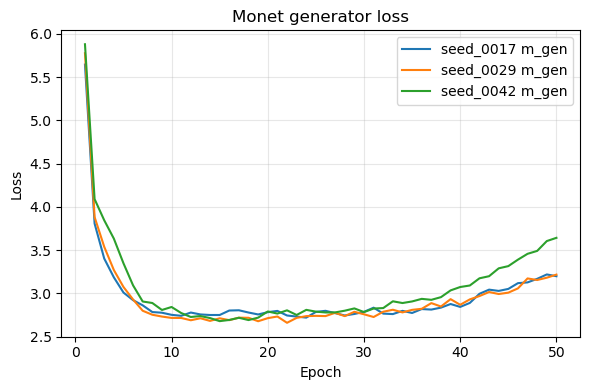

In [25]:
plt.figure(figsize=(6, 4))

for rd in run_dirs:
    csv_path = Path(rd) / "training_log.csv"
    epochs, losses = [], []

    with open(csv_path, newline="") as f:
        reader = csv.DictReader(f)
        for row in reader:
            epochs.append(int(row["epoch"]) + 1)           
            losses.append(float(row["monet_gen_loss"]))    

    plt.plot(epochs, losses, label=f"{Path(rd).name} m_gen")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Monet generator loss")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

In [26]:
# Paths
OUTPUT_ROOT = "./experiments"
DATA_ROOT   = "./gan-getting-started"
REAL_MONET_DIR = "./monet_jpgs_for_eval"

# Export Monet JPGs from TFRecords if needed
MONET_FILENAMES = tf.io.gfile.glob(str(Path(DATA_ROOT) / "monet_tfrec" / "*.tfrec"))
mf.ensure_monet_jpgs_from_tfrec(MONET_FILENAMES, REAL_MONET_DIR)

# Evaluate MiFID per run
run_dirs = sorted(p for p in Path(OUTPUT_ROOT).glob("seed_*") if p.is_dir())
rows = []
for rd in run_dirs:
    gen_dir = rd / "generated_full"
    res = mf.compute_mifid(REAL_MONET_DIR, gen_dir, epsilon=0.10, batch=64)
    rows.append({"run": rd.name, **res})

# Sort by MiFID 
rows.sort(key=lambda r: r["MiFID"])

# Per-run table
print("\nMiFID results (sorted by MiFID):")
print(f"{'run':<12} {'FID':>10} {'d':>10} {'d_thr':>10} {'MiFID':>12}")
for r in rows:
    print(f"{r['run']:<12} {r['FID']:>10.4f} {r['d']:>10.4f} {r['d_thr']:>10.4f} {r['MiFID']:>12.4f}")

# Summary across runs (mean & std)
def mean_std(vals):
    arr = np.asarray(vals, dtype=float)
    n = arr.size
    mean = float(arr.mean()) if n else float("nan")
    std  = float(arr.std(ddof=1)) if n > 1 else 0.0
    return mean, std

metrics = ["FID", "MiFID"]
print("\nSummary across runs:")
print(f"{'metric':<8} {'mean':>12} {'std':>12}")
for m in metrics:
    mean, std = mean_std([r[m] for r in rows])
    print(f"{m:<8} {mean:>12.4f} {std:>12.4f}")

[mifid] Exported 300 Monet images to ./monet_jpgs_for_eval

MiFID results (sorted by MiFID):
run                 FID          d      d_thr        MiFID
seed_0042       86.7320     0.2475     1.0000      86.7320
seed_0017       88.8719     0.2507     1.0000      88.8719
seed_0029       91.9136     0.2526     1.0000      91.9136

Summary across runs:
metric           mean          std
FID           89.1725       2.6039
MiFID         89.1725       2.6039
